In [1]:
import sys; sys.path.append('..')
from multiprompt import *
import plotnine as p9
# !pip uninstall numpy -y
# !pip install numpy
# !pip install gender-guesser

In [2]:
@cache
def genderizer():
    import gender_guesser.detector as gender
    d = gender.Detector()
    return d


In [6]:
class NameTitleGenrePicker(AgentModel):
    system_prompt = """
You are a novelist who is preparing a long novel to be published in three separate volumes. Return the following information in valid JSON form:

{
    "name": "Your Name",
    "title": "Your Novel Title",
    "genre": "Your Genre",
    "year": "The year of the novel",
    "description": "A short 1 sentence summary of the novel"
}

Choose from the following options:

* name: Any name whatsoever
* title: Any title whatsoever, befitting the genre and year
* genre: Choose from "Literary Fiction", "Romance", "Science Fiction", "Fantasy"
* year: Choose a year between 1719 and 2019
* description: A short 1 sentence summary of the novel mentioning key characters, befitting the year and genre

Do not return any other text besides the JSON. Do not encapsulate it in ``` characters.""".strip()
    model = 'gpt-3.5-turbo'

    def get_name_info(self, name):
        if ',' in name:
            return self.get_name_info(name.split(',',1)[-1])
        try:
            first_name = name.strip().split()[0]
            return {'gender': genderizer().get_gender(first_name)}
        except Exception as e:
            return {'gender':'unknown'}

    def postprocess_output(self, output:str) -> dict:
        try:
            data = dirty_json_loads(output)
            if data.get('name'):
                data = {**data, **self.get_name_info(data.get("name"))}
            return data
        except Exception as e:
            logger.warning(f'{e} ON INPUT {output}')
            return
        
    def represent_output(self, postprocessed_output:dict):
        response_str='\n'.join(f'{k}: {str(v).upper()}' for k,v in postprocessed_output.items())
        return response_str

class MiniStoryWriter(AgentModel):
    system_prompt = """
You are [[author]], a novelist who is preparing your [[genre]] novel titled [[title]] to be published. Your editor wants a summary of the story, including character names, descriptions, their interactions, relations, and any other aspects of plot development. Write this summary in 500 words. Do not return any other text besides your summary.
""".strip()
    model = 'gpt-4o-mini'

# NameTitleGenrePicker().generate(_force=False)
agent = NameTitleGenrePicker()
# agent.results

In [7]:
wf=Workflow([agent])

In [130]:
decs=list(range(1700,2020,10))
random.shuffle(decs)
for dec in progress_bar(decs, desc='Iterate'):
    wf.sweep(f'You are writing in the {dec}s. Choose a year within that decade. Do NOT choose a real author but invent your own writing at that time.', n=10, models=['gpt-4o-mini'])

[241.09s] Iterate:  28%|██▊       | 9/32 [05:36<18:22, 47.92s/it]ERROR:multiprompt.imports:Error in generate_async: litellm.APIError: APIError: OpenAIException - Connection error.
                                                                 


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm.set_verbose=True'.



APIError: litellm.APIError: APIError: OpenAIException - Connection error.

In [117]:
picker = NameTitleGenrePicker()

l = []
for fn in [
    '/Users/ryan/Downloads/merged_fiction_metadata.csv', 
    '/Users/ryan/Downloads/filtered_fiction_metadata.csv', 
    '/Users/ryan/Downloads/filtered_fiction_plus_18c.tsv'
]:
    dfx = pd.read_csv(fn, sep=',' if not '.tsv' in fn else '\t')
    l.append(dfx)
df_human = pd.concat(l).fillna('').drop_duplicates('volid')
df_human = df_human[df_human['author']!=""]
picker = NameTitleGenrePicker()
df_human['gender'] = df_human['author'].apply(lambda x: picker.get_name_info(x).get('gender'))
df_human['gender_real'] = df_human['authgender'].apply(lambda x: {'m':'male', 'f':'female', 'u':'unknown'}.get(x))
df_human


,docid,volid,recordid,author,firstname,inferreddate,birthdate,authgender,enumcron,title,gender,gender_real
1,13137,hvd.hn2he3,,"Kendall, Edward Augustus,",,1800,,m,,"The stories of Senex, or, Little histories of ...",unknown,male
2,1783,uc2.ark+=13960=t0vq2tk41,,"Wordboise, Emma Jane.",,1800,,f,,Lady Clarissa,female,female
3,14101,nyp.33433074913272,,"Hervey, Elizabeth,",,1800,,f,v. 2,The Mourtray family,unknown,female
4,13202,nyp.33433074955018,,"Lathom, Francis,",,1800,,m,v. 3,Men and manners,unknown,male
5,5423,mdp.39015059375132,,"[Burges, Mary Anne]",,1800,,f,,"The progress of the pilgrim Good-Intent, in Ja...",mostly_female,female
...,...,...,...,...,...,...,...,...,...,...,...,...
250,4673,nyp.33433067307516,,<blank>,,1786,,m,t. 2,"Tales, romances, apologues, anecedotes and novels",unknown,male
251,6018,uc2.ark:/13960/t1mg7h137,,<blank>,,1791,,u,,The wonder working water-mill displayed with i...,unknown,unknown
252,6150,mdp.39015059896913,,<blank>,,1780,,u,,An entire new collection of romances and novels,unknown,unknown
253,10963,nyp.33433074955075,,<blank>,,1795,,u,,Letters of an Italian nun and an English gentl...,unknown,unknown


In [118]:
# !wget "https://www.dropbox.com/s/1o81aj6akxpp90c/estc_metadata.zip?dl=1" -O estc_metadata.zip
# !unzip estc_metadata.zip

In [119]:
df_estc = pd.read_csv('metadata.csv').query('form=="Fiction"')
df_estc

,_llp_,author,author_dates,book_dimensions,book_dimensions_standard,book_extent,book_extent_num_pages,corpus,form,form_marc,...,pub_region,pub_statement,subject_person,subject_place,subject_topic,title,title_sub,year,year_end,year_type_marc
4,estc|000/N023416,NaN,NaN,12⁰,2,"4],xii,115,[1]p.",115.0,ESTC,Fiction,|,...,England,"printed for F. Wingrave, successor to Mr. Nour...",NaN,NaN,Sanskrit fiction,The story of Dooshwanta and Sakoontal�a,"Translated from the Mah�abh�arata, a poem in t...",1795,NaN,s
203,estc|001/T091523,S. A,NaN,8⁰,8,"6],32p.",32.0,ESTC,Fiction,|,...,England,printed and sold by J. Baker and T. Warner,NaN,NaN,"Political fiction, English",The true Englishman's character. In a letter t...,NaN,1717,NaN,s
728,estc|005/T224597,NaN,NaN,8⁰,8,48p.,48.0,ESTC,Fiction,|,...,England,"Printed for, and sold by J. Sadler, M. Clement...",NaN,NaN,"Adventure stories, English","The Astonishing history, and adventures of Mis...",NaN,1799,NaN,s
839,estc|006/T167718,NaN,NaN,12⁰,2,8p.,8.0,ESTC,Fiction,|,...,England,s.n,NaN,NaN,"Religious fiction, English",The history of that holy disciple Joseph of Ar...,"Wherein is contained, the true account of his ...",1710,NaN,s
1044,estc|008/T072040,NaN,NaN,8⁰,8,8p.,8.0,ESTC,Fiction,|,...,England,NaN,NaN,NaN,English fiction,The miracle of miracles Being a full and true ...,NaN,1715,NaN,s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481161,estc|ffb/N014250,"Godard d'Aucour, Claude",NaN,12⁰,2,"8,13-220p.",220.0,ESTC,Fiction,|,...,England,"printed for J. Cattermoul, No. 376, Oxford-Str...",NaN,NaN,French fiction,Themidore. A novel,Translated from the French. By a citizen of th...,1783,NaN,s
481380,estc|ffc/T223405,NaN,NaN,8⁰,8,"45,[3]p.",45.0,ESTC,Fiction,|,...,England,printed by H. Parker in Goswell-Street,NaN,NaN,English fiction,Of the stupendous gout-stone,see page the 28. II. An introduction to a new ...,1723,NaN,s
481593,estc|ffe/T230713,NaN,NaN,12⁰,2,"35,[1]p.",35.0,ESTC,Fiction,|,...,England,"Printed and sold by John Raw, sold also by Mes...",NaN,NaN,English fiction,"The Adventures of William Blair, a trooper and...",NaN,1800,NaN,s
481681,estc|fff/T135122,NaN,NaN,12⁰,2,108p.,108.0,ESTC,Fiction,|,...,England,"printed by T. Sabine and Son, 81, Shoe Lane, F...",NaN,NaN,Guy of Warwick (Legendary character | Historic...,"The history of Guy, Earl of Warwick",containing a full and true account of his many...,1800,NaN,s


In [120]:
from tqdm import tqdm
tqdm.pandas()

picker = NameTitleGenrePicker()

df_estc['year'] = pd.to_numeric(df_estc['year'], errors='coerce')
df_estc['author'] = df_estc['author'].fillna("")
df_estc = df_estc[(df_estc.author!="") & (~df_estc.year.isna())]
df_estc = df_estc[df_estc.author.str.contains(',')]
df_estc['gender'] = df_estc['author'].progress_apply(lambda x: picker.get_name_info(x).get('gender'))
df_estc

100%|██████████| 1476/1476 [00:00<00:00, 331839.23it/s]


,_llp_,author,author_dates,book_dimensions,book_dimensions_standard,book_extent,book_extent_num_pages,corpus,form,form_marc,...,pub_statement,subject_person,subject_place,subject_topic,title,title_sub,year,year_end,year_type_marc,gender
1541,estc|00c/T093422,"Donellan, John",NaN,8⁰,8,"2],96p.,plate",96.0,ESTC,Fiction,|,...,"Printed for J. Jackson, Pater-Noster-Row",NaN,NaN,Biographical fiction,"The life of Capt. John Donnellan, late master ...",Including an account of Capt. Donnellan's tran...,1781,NaN,s,male
1663,estc|00d/T071311,"Cullen, Stephen",NaN,12⁰,2,"2],262p.",262.0,ESTC,Fiction,|,...,"printed for William Jones, Dame-Street",NaN,NaN,English fiction,The haunted priory,"or, the fortunes of the house of Rayo. A roman...",1794,NaN,s,male
2252,estc|012/T178143,"More, Hannah",NaN,12⁰,2,"22,[2]p.",22.0,ESTC,Fiction,|,...,"Sold by William Watson and Son, No.7, Capel-St...",NaN,NaN,English fiction,"Cheap Repository. The two wealthy farmers, wit...",NaN,1797,NaN,s,female
2627,estc|015/T227105,"Littlejohn, P",NaN,12⁰,2,2v.,2.0,ESTC,Fiction,|,...,"Printed for William Lane, at the Dinerba press...",NaN,NaN,English fiction,"Henry, a novel. In two volumes. By the author ...",NaN,1793,NaN,s,unknown
2654,estc|016/N047388,"McCarthy, Charlotte",NaN,12⁰,2,"69,[3]p.",69.0,ESTC,Fiction,|,...,"printed by A. Reilly, for William Ranson Books...",NaN,NaN,English fiction,The fair moralist,"or, love and duty. A novel. A narrative, which...",1747,NaN,s,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480167,estc|ff2/T096270,"Tiphaigne de la Roche, Charles-Fran�cois",NaN,12⁰,2,"111,[1]p.",111.0,ESTC,Fiction,|,...,printed for W. Needham over-against Gray's-Inn...,NaN,NaN,French fiction,"Amilec, or the seeds of mankind. Translated fr...",NaN,1753,NaN,s,unknown
480522,estc|ff5/T139039,"Olivier, J",abb�e,12⁰,2,"278,[2]p.",278.0,ESTC,Fiction,|,...,s.n,NaN,NaN,French fiction,"The history of the life, and surprizing advent...",Of the Hague Giving a particular Account of hi...,1742,NaN,s,unknown
480632,estc|ff6/T120326,"Hill, John",NaN,8⁰,8,"16],72p.",72.0,ESTC,Fiction,|,...,s.n,NaN,NaN,French fiction,Lucina sine concubitu. Lettre address�ee �a la...,NaN,1750,NaN,s,male
481128,estc|ffa/T133516,"Haweis, Thomas",NaN,12⁰,2,2v.,2.0,ESTC,Fiction,|,...,"printed for T. and W. Lowndes, No. 77, Fleet-s...",NaN,NaN,English fiction,Memoirs of the Manstein family,"Pathetic, sentimental, humorous, and satirical...",1783,NaN,s,male


In [121]:
df = wf.results_df
df=df.reset_index()

df_human1 = df_human.assign(agent='human',model='human_est').rename(
    columns={'author':'name', 'inferreddate':'year', 'title':'title', 'gender':'gender'}
)
df_human2 = df_human.assign(agent='human',model='human_real').rename(
    columns={'author':'name', 'inferreddate':'year', 'title':'title', 'gender_real':'gender'}
)
df_human = pd.DataFrame([
    d
    for df in [df_human1, df_human2]
    for d in df.to_dict(orient='records')
]).drop_duplicates(['volid','model'])

df = pd.concat([df, df_human, df_estc[['author','year','title','gender']].assign(agent='human', model='human_est')])
df

    "name": "Astrid Wellsley",
    "title": "Moonlit Revival of 1875",
    "genre": "Fantasy",
    "year": "1887",
    "description": "In a world where clockwork machines reign supreme, enigmatic inventor Arachne Wilder must reconcile her troubled past with her destiny to unite the scattered fragments of humanity before an ancient prophecy unfolds."


,position,agent,user_prompt,max_tokens,temperature,model,name,title,genre,year,...,gender,docid,volid,recordid,firstname,birthdate,authgender,enumcron,gender_real,author
0,1.0,NameTitleGenrePicker,Follow any instructions given in the system pr...,1024.0,0.002,claude-3-haiku-20240307,Emily Bronte,Wuthering Heights,Literary Fiction,1847,...,female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NameTitleGenrePicker,Follow any instructions given in the system pr...,1024.0,0.002,gpt-4o,Alexandra Grey,The Celestial Chronicles,Fantasy,2019,...,female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NameTitleGenrePicker,Follow any instructions given in the system pr...,1024.0,0.003,claude-3-haiku-20240307,Emily Bronte,Wuthering Heights,Literary Fiction,1847,...,female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NameTitleGenrePicker,Follow any instructions given in the system pr...,1024.0,0.003,gpt-3.5-turbo,Eleanor Smith,Whispers of the Enchanted Forest,Fantasy,2019,...,female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NameTitleGenrePicker,Follow any instructions given in the system pr...,1024.0,0.008,claude-3-haiku-20240307,Emily Bronte,Wuthering Heights,Literary Fiction,1847,...,female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480167,NaN,human,NaN,NaN,NaN,human_est,NaN,"Amilec, or the seeds of mankind. Translated fr...",NaN,1753,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Tiphaigne de la Roche, Charles-Fran�cois"
480522,NaN,human,NaN,NaN,NaN,human_est,NaN,"The history of the life, and surprizing advent...",NaN,1742,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Olivier, J"
480632,NaN,human,NaN,NaN,NaN,human_est,NaN,Lucina sine concubitu. Lettre address�ee �a la...,NaN,1750,...,male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Hill, John"
481128,NaN,human,NaN,NaN,NaN,human_est,NaN,Memoirs of the Manstein family,NaN,1783,...,male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Haweis, Thomas"


In [122]:
# df['temp_bin'] = (df['temperature'].fillna(-1) * 10).astype(int)
# df['year'] = pd.to_numeric(df['year'], errors='coerce')
# df['year_bin'] = df['year'].apply(str).apply(lambda x: f'C{int(x[:2])+1 if x[:2] and x[:2].isdigit() else x}' )
# df = df[df['year_bin']!='Cnan'].query('1719 <= year <= 2019')


# def quantify_categories(df, groupby=['year_bin','genre'], count_by=['gender']):
#     l=[]
#     for gby,group in df.groupby(groupby):
#         d = dict(zip(groupby,gby))
#         for c in count_by:
#             cd = group[c].value_counts().to_dict()
#             cdsum = int(sum(cd.values()))
#             for k,v in cd.items():
#                 d[f'{c}_{k}'] = v
#                 d[f'{c}_{k}_norm'] = v/cdsum
#         l.append(d)
#     df2=pd.DataFrame(l).fillna(0)
#     return df2


# def plot_temperature_boxplots(df):
#     # !pip install plotnine
#     import plotnine as p9
#     import pandas as pd
#     p9.options.figure_size=(12,8)
#     df=df.copy()
#     df = df[df.model.isin({'claude-3-haiku-20240307', 'gpt-3.5-turbo','human'})]
#     df['gender'] = df['gender'].apply(lambda x: 'Female' if 'female' in x else 'Male' if 'male' in x else 'Non-Binary')
    
#     gby=['gender','agent']
#     # df['year_bin'] = df['year_bin'].apply(lambda x: f'{x}s')
#     df['year_bin'] = pd.Categorical(df['year_bin'], categories=df['year_bin'].sort_values(ascending=True).unique())
#     df['group'] = ['_'.join(str(y) for y in x) for x in list(zip(*list(df[c] for c in gby)))]
#     df['group'] = pd.Categorical(df['group'], categories=df['group'].sort_values(ascending=False).unique())
#     fig = p9.ggplot(df, p9.aes(x='agent', y='temperature', color='agent')) + p9.geom_boxplot() + p9.geom_point() + p9.facet_grid('year_bin ~ gender') + p9.coord_flip() + p9.theme_classic()
#     return fig

# plot_temperature_boxplots(df)

In [123]:
# def plot_density(df):
#     import plotnine as p9
#     # df['group'] = ['_'.join(str(y) for y in x) for x in list(zip(*list(df[c] for c in gby)))]
#     # df['group'] = pd.Categorical(df['group'], categories=df['group'].sort_values(ascending=False).unique())
#     fig=p9.ggplot(df, p9.aes(x='gender',fill='gender'))
#     fig+=p9.geom_bar(position='dodge')
#     fig+=p9.theme_classic()
#     fig+=p9.coord_flip()
#     fig+=p9.facet_grid('year_bin ~ model')
#     return fig

# # plot_density(df)

In [127]:
def plot_not_male(df):
    p9.options.figure_size=11,8

    df=df.copy()
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df=df.query('2020>year>=1800').sort_values('year')
    df['yearbin'] = (df['year'] // 20 * 20).apply(int)
    df['freq_not_male'] = df['gender'].apply(lambda x: int('male' not in x or 'female' in x))
    df['freq_male'] = df['gender'].apply(lambda x: int('male' in x and 'female' not in x))
    df['freq_female'] = df['gender'].apply(lambda x: int('female' in x))
    df['freq_nonbinary'] = df['gender'].apply(lambda x: int(not 'male' in x))
    df['freq_total'] = 1
    agg={}
    for c in df:
        if c.startswith('freq_'):
            df[c.replace('freq_','count_')] = df[c]
            agg[c.replace('freq_','count_')] = 'sum'
            agg[c] = 'mean'
    
    agg['temperature'] = 'mean'
    agg['year'] = 'median'
    df['temp_bin'] = pd.cut(df['temperature'], bins=3)
    # df = df[df.model.isin({'claude-3-haiku-20240307', 'gpt-3.5-turbo','human_est','human_real'})]

    gby=['yearbin','agent','model']
    
    l=[]
    min_grp_size=10
    for g,gdf in df.groupby(gby):
        if len(gdf)<min_grp_size:
            continue
        d = gdf.agg(agg).to_dict()
        d['female_male_count'] = d.get('count_female')+d.get('count_male')
        d['female_male_ratio'] = d.get('count_female')/d['female_male_count']
        outd = {**dict(zip(gby,g))}
        outd['feature'] = 'female_male_ratio'
        outd['freq'] = d.get('female_male_ratio')
        outd['count'] = d['female_male_count']
        l.append(outd)
    figdf = pd.DataFrame(l)
    fig = p9.ggplot(figdf, p9.aes(x='yearbin',y='freq',color='agent'))
    fig+=p9.geom_point(p9.aes(size='count',shape='model'),alpha=.75)
    fig+=p9.geom_line(p9.aes(group='model'))
    fig+=p9.scale_size_continuous(range=[2,10])
    fig+=p9.facet_wrap('model',nrow=1)
    fig+=p9.theme_classic()
    return fig

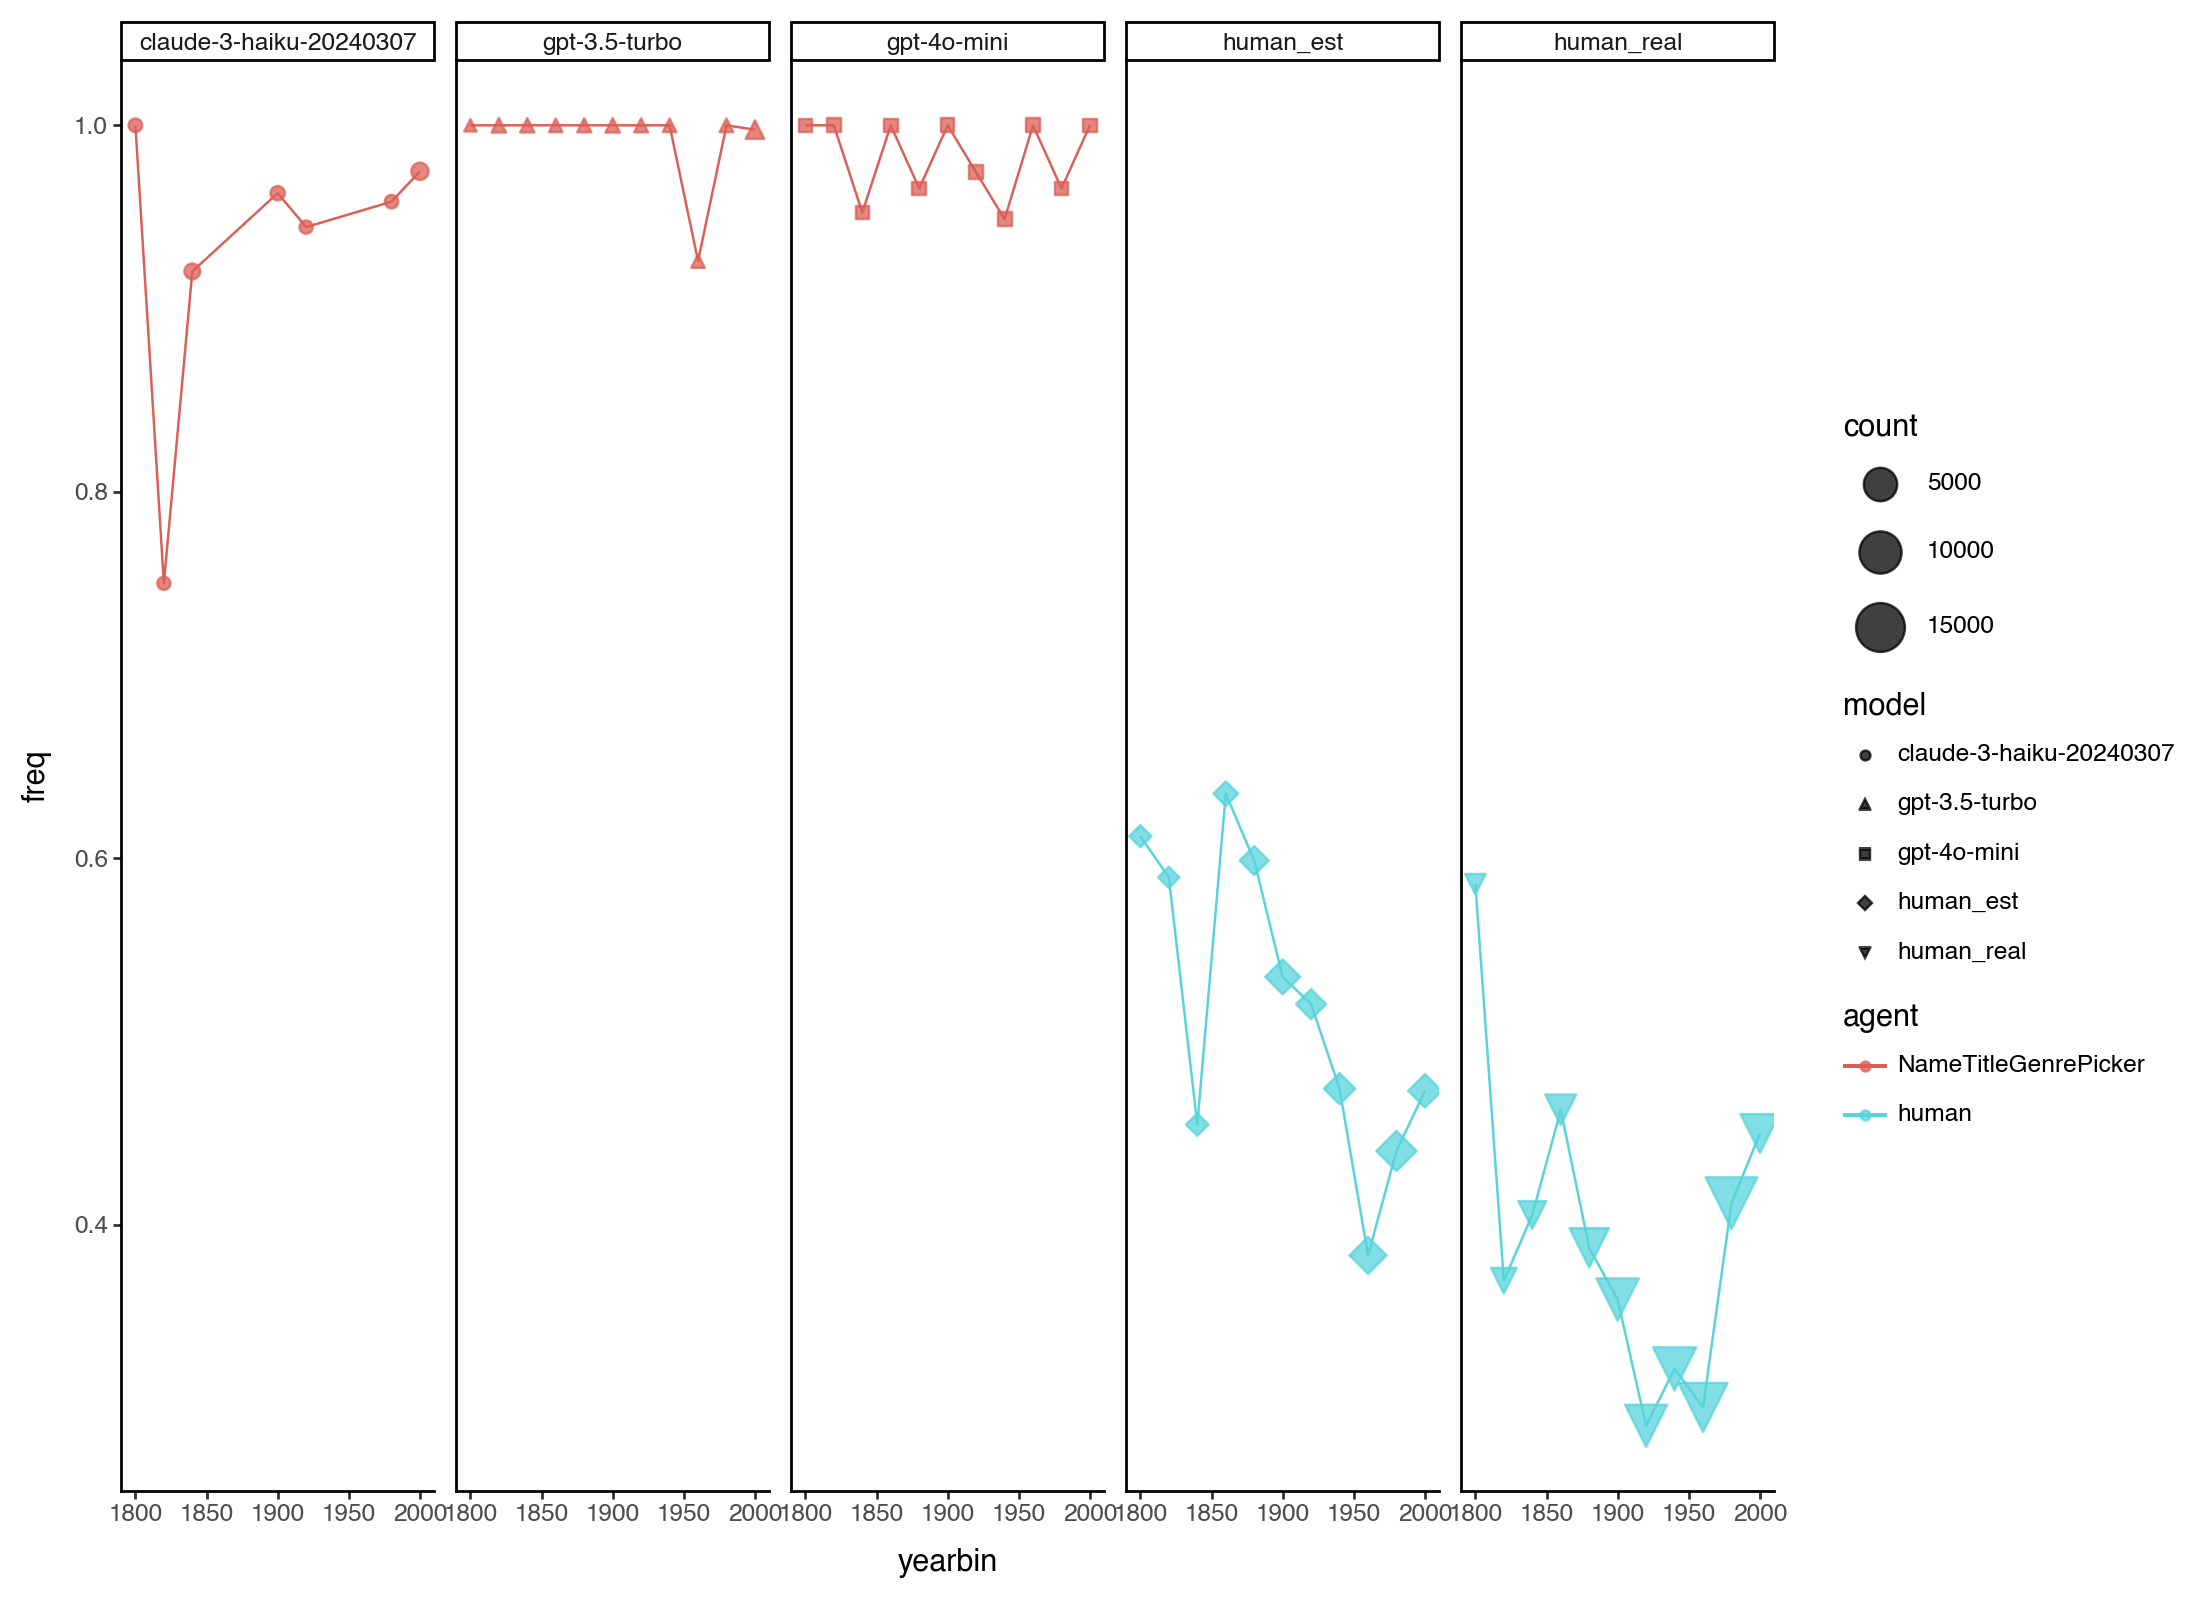

In [128]:
plot_not_male(df)

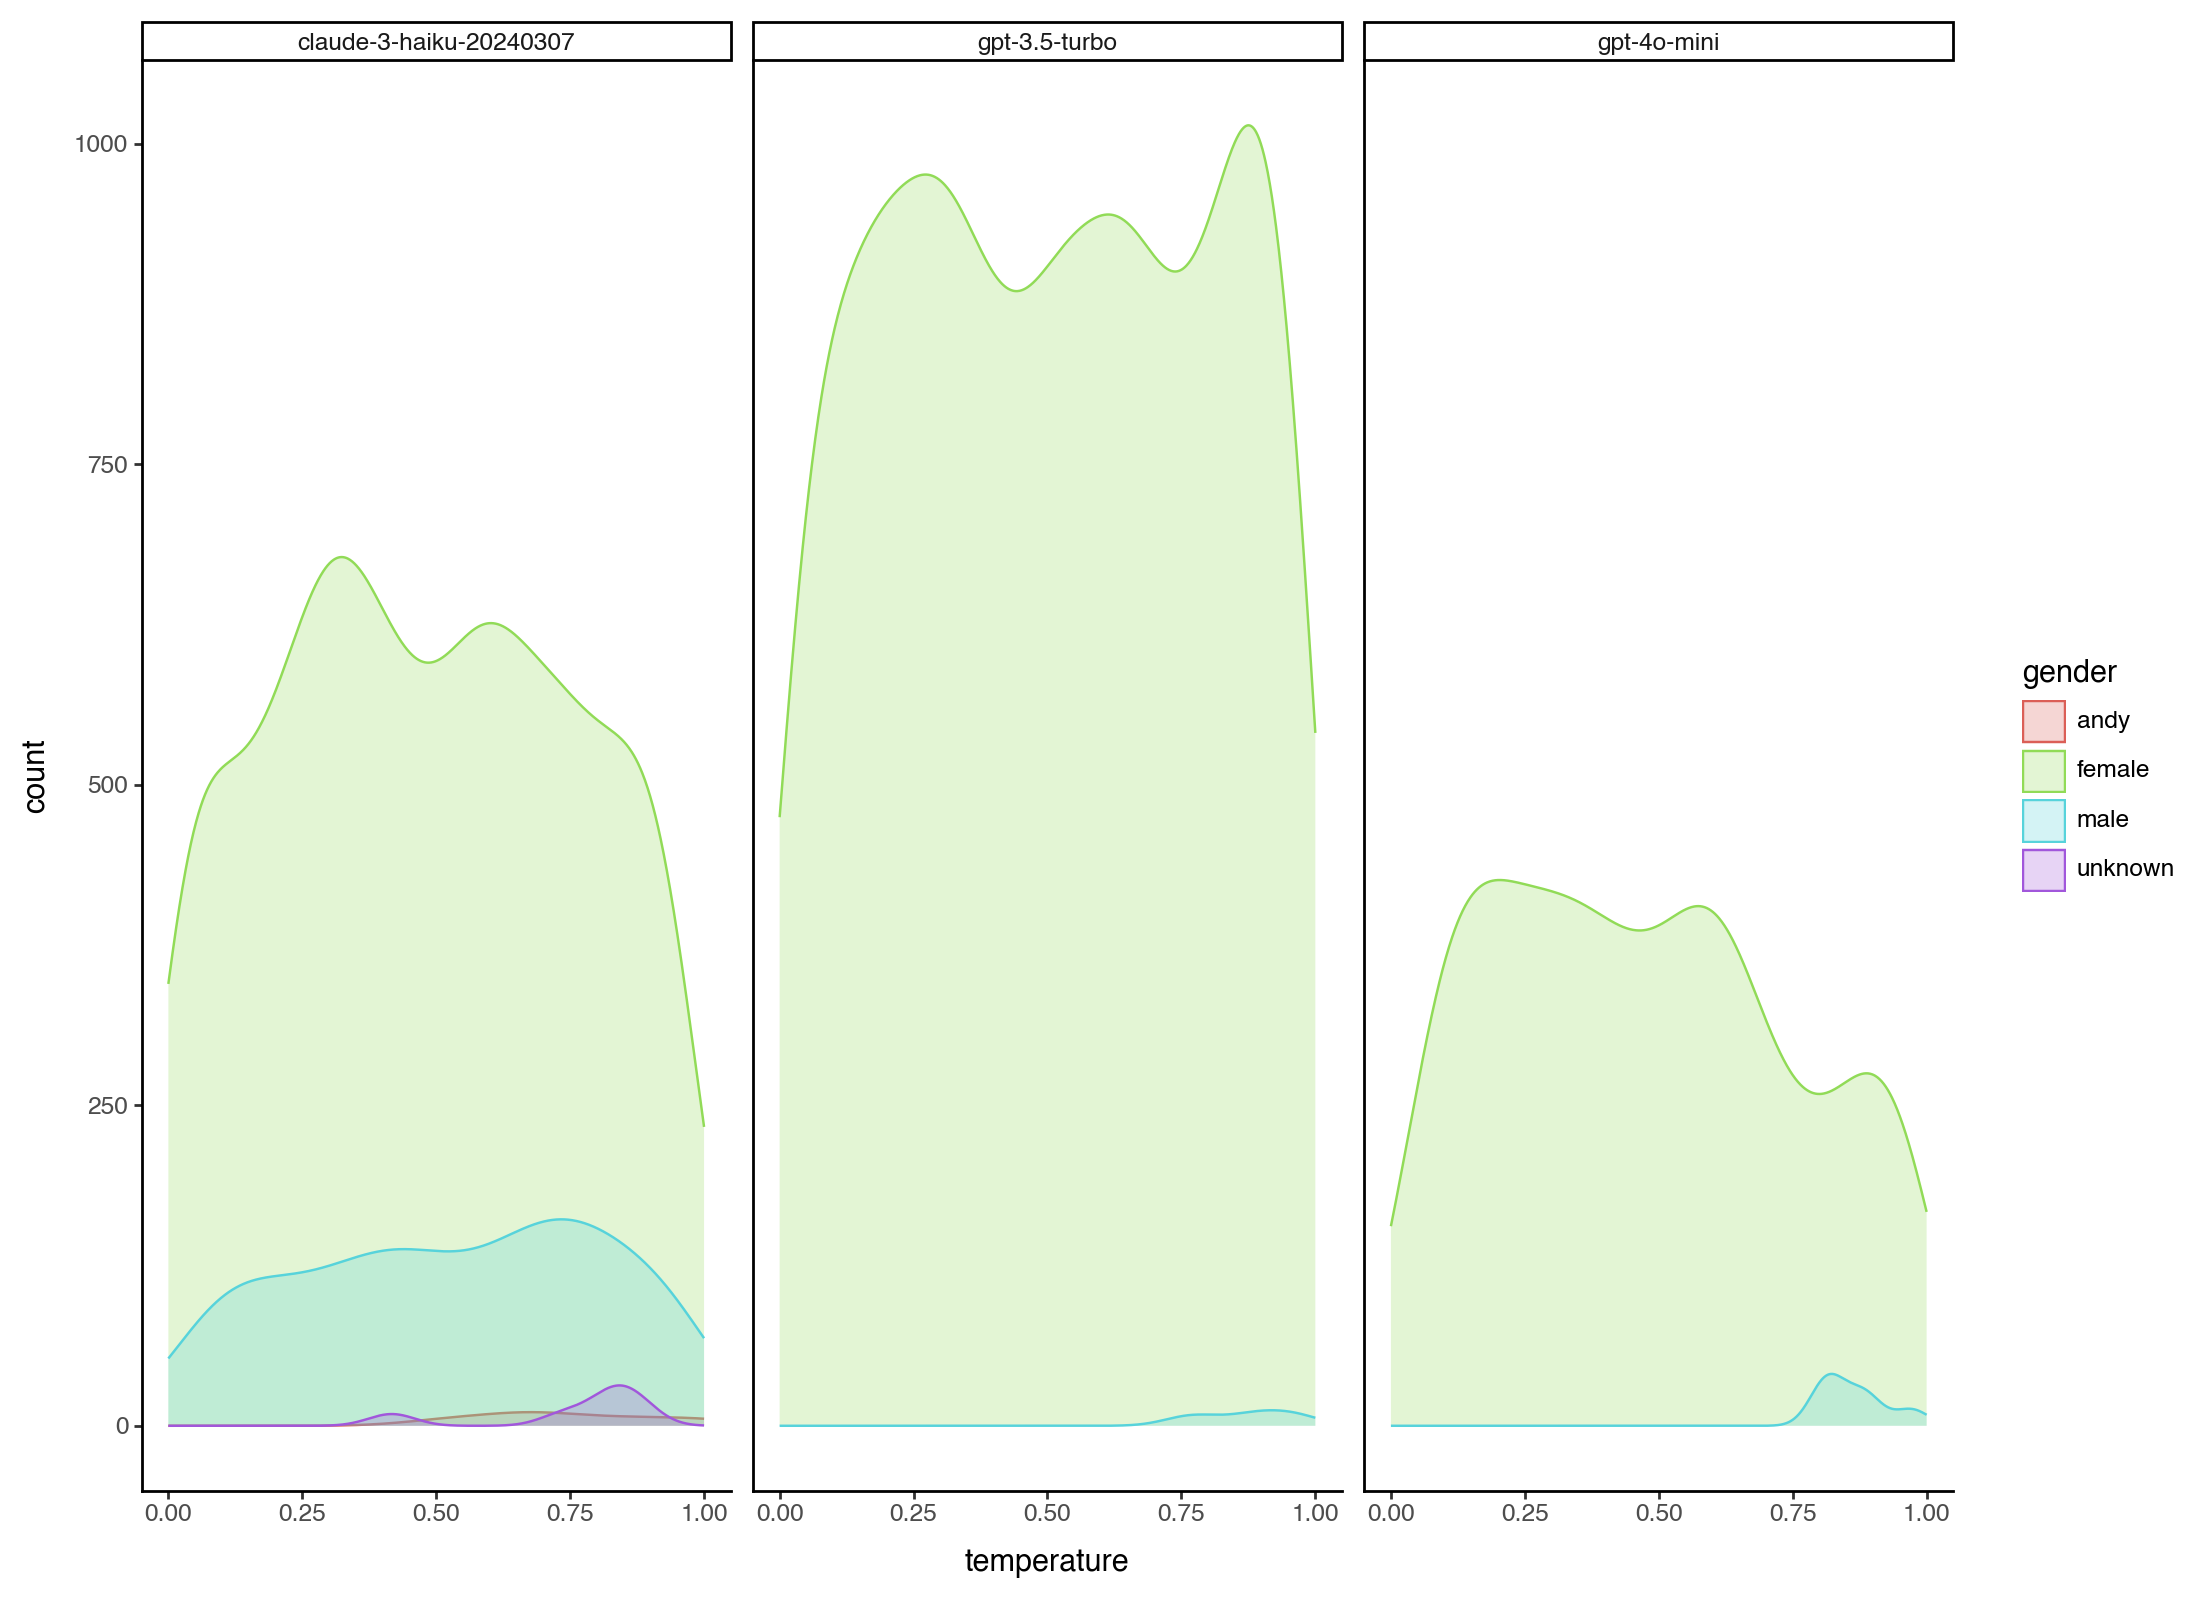

In [126]:
figdf = df.copy().query('0<=temperature<=1')
figdf = figdf[figdf.model.isin({'claude-3-haiku-20240307', 'gpt-3.5-turbo', 'gpt-4o-mini'})]
figdf['gender'] = figdf['gender'].apply(lambda x: x.replace('mostly_',''))
fig = p9.ggplot(figdf.query('agent!="human"'), p9.aes(x='temperature', color='gender', fill='gender'))
fig+= p9.facet_wrap('model')
# fig+= p9.facet_grid('model ~ year_bin')
fig+= p9.geom_density(p9.aes(y=p9.after_stat("count")), alpha=.25)
fig+=p9.theme_classic()
fig

In [100]:
# def plot_binary(df):
#     figdf = df.copy()
    
#     fig = p9.ggplot(figdf, p9.aes(x='yearbin',y='value',color='feature', shape='model'))
#     fig+=p9.geom_point(size=3, alpha=.5)
#     fig+=p9.facet_wrap('genre')
#     fig+=p9.geom_smooth(method='lm',se=False)
#     fig+=p9.theme_classic()
#     return fig

In [14]:

# Melt the dataframe to long format
df_melted = df2.melt(id_vars=['agent', 'year_bin', 'genre'], 
                     value_vars=['gender_female_norm', 'gender_male_norm', 'gender_unknown_norm'],
                     var_name='gender', value_name='normalized_count')

# Clean up gender column
df_melted['gender'] = df_melted['gender'].str.replace('gender_', '').str.replace('_norm', '')

# Create the plot
plot = (p9.ggplot(df_melted, p9.aes(x='temperature', y='normalized_count', color='gender'))
 + p9.geom_line()
 + p9.geom_point()
 + p9.facet_wrap('year_bin')
 + p9.labs(title='Gender Distribution in Different Genres Over Time',
        x='Year',
        y='Normalized Gender Count')
 + p9.theme_classic()
 + p9.theme(figure_size=(12, 8),
         axis_text_x=p9.element_text(angle=45, hjust=1),
         legend_position='right')
)

# Display the plot
print(plot)


NameError: name 'df2' is not defined

In [ ]:
len(wf.agents[1].results)

IndexError: list index out of range

In [ ]:
class MiniStoryWorkflow(Workflow):
    def __init__(self, agents=None):
        super().__init__([NameTitleGenrePicker(), MiniStoryWriter()] if agents is None else agents)

    def run(self, user_prompt=None, _force=False, **prompt_kwargs):
        if _force or not self._run:
            agent1 = self.agentd['NameTitleGenrePicker']
            agent2 = self.agentd['MiniStoryWriter']
            
            response1 = agent1.generate(user_prompt=user_prompt, repr=True, _force=_force, verbose=True,**prompt_kwargs)
            response2 = agent2.generate(user_prompt=response1, _force=_force, verbose=True)

    

# MiniStoryWorkflow().run_df()
wf=MiniStoryWorkflow()
[agent.position for agent in wf.agents]

[1, 2]

In [ ]:
wf.run_df()

13:16:49 - LiteLLM:INFO: utils.py:2960 - 
LiteLLM completion() model= gpt-4o; provider = openai
INFO:LiteLLM:
LiteLLM completion() model= gpt-4o; provider = openai
{
    "name": "Isabella Thornton",
    "title": "Shadows of the Ancients",
    "genre": "Gothic",
    "year": "1837",
    "description": "In the haunted halls of Ravenswood Manor, Eliza must unravel her family's dark secrets to save her soul from an ancient curse."
}13:16:51 - LiteLLM:INFO: utils.py:2960 - 
LiteLLM completion() model= gpt-4o; provider = openai
INFO:LiteLLM:
LiteLLM completion() model= gpt-4o; provider = openai
In the Gothic novel "Shadows of the Ancients," set in the year 1837, Isabella Thornton crafts a haunting tale of mystery, darkness, and the supernatural within the eerie confines of Ravenswood Manor. The story revolves around Eliza Ravenswood, a determined and intelligent young woman with a fiery spirit and a shadowed past. Eliza, recently orphaned, returns to her ancestral home, Ravenswood Manor, situ

In [ ]:
n = NameTitlePicker(temperature=1.5)
n.to_dict()

NameError: name 'NameTitlePicker' is not defined

In [ ]:
n.key

{'name': 'NameTitlePicker', 'position': 1}

In [ ]:
n.generate(user_prompt='Follow the system instructions, with the added context that you are a novelist writing in the year 2212.',_force=True)

<multiprompt.prompts.Prompt object at 0x105e47910> <multiprompt.prompts.Prompt object at 0x11f0d7f10> True


{'title': 'Futurescape Chronicles: Redeemers of Unity',
 'author': 'Ellis Novak'}

In [ ]:
n.generate(user_prompt='Follow the system instructions, with the added context that you are a novelist writing in the year 2212!')


<multiprompt.prompts.Prompt object at 0x105e47910> <multiprompt.prompts.Prompt object at 0x11f0d17b0> False
<multiprompt.prompts.Prompt object at 0x105e47250> <multiprompt.prompts.Prompt object at 0x11f0d17b0> True


{'title': 'Celestial Echoes', 'author': 'Meliora Woodsgen'}

In [ ]:
Conversation(agents=[NameTitlePicker(), ])

title  \
name            position model  system_prompt                                      user_prompt                                        max_tokens temperature                                               
NameTitlePicker 1        gpt-4o \nYou are a novelist who is preparing a long no... Follow the system instructions, with the added ... 1024       1.5                                    Celestial Echoes   
                                                                                   Follow the system instructions, with the added ... 1024       1.5                                         Time's Echo   
                                                                                                                                                 1.5          Futurescape Chronicles: Redeemers of Unity   

                                                                                                                                                                                                author  
name            position model  system_prompt                                      user_prompt                                        max_tokens temperature                                            
NameTitlePicker 1        gpt-4o \nYou are a novelist who is preparing a long no... Follow the system instructions, with the added ... 1024       1.5                                  Meliora Woodsgen  
                                                                                   Follow the system instructions, with the added ... 1024       1.5          Jayden Alba-432 اليابітsin Мор'oublenkil  
                                                                                                                                                 1.5                                       Ellis Novak